# Simulation

This is all the code for the simulation of the market, including the traders, the asset and the market mechanism.

In [19]:
import numpy as np #import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import pymarket as pm
import math
import csv
import pprint

We start my initialising the trading asset, as well as t previous random prices so that the technical analyst traders have some material to make their initial trading decisions. These random prices will be kept constant throughout simulations so they don't affect the decisions of the traders between rounds. The price at t=0 will be 100 so price movements during the simulation are normalised to an index.

In [15]:
t = 100
period = []
start = -t+1

for i in range(t):
    period.append(start)
    start += 1
    
# asset_prices_rev = []
# price = 100

# for i in range(t):
    # asset_prices_rev.append(price)
    # price = price + np.random.normal(loc=-0.09, scale=1.0, size=None)
    
asset_prices_rev_final = [100, 100.01270443267846, 100.64019372161697, 98.81839318571531, 99.30899479777956, 97.51859080046586, 99.22427385535754, 99.44545557876086, 99.52622326159883, 99.23209122576705, 101.52132601414174, 101.30141646048006, 100.89710059388699, 100.46473999622577, 100.75961538456453, 101.88499554537094, 100.80411278857896, 101.72248034025961, 101.12565566539686, 100.26632483034365, 100.91562712976665, 99.17772539309188, 99.59066814732586, 99.75049301170291, 99.88257405096272, 101.67780729403768, 101.20291667999382, 101.94670634215417, 101.10767031065018, 101.81291988910793, 101.30365747376271, 99.2424041923615, 100.8833495441585, 99.78836505154021, 99.33535482264746, 98.97871646915819, 99.06522794959744, 98.30142009719744, 98.79170348115102, 97.6910991393464, 95.44595047877094, 96.06814982285735, 95.72056059028928, 95.98006873492281, 96.66174879041085, 97.10418900617363, 96.20190098646628, 95.95299800697686, 96.99590538116517, 97.81622741995606, 96.3887487724033, 97.77586186321399, 95.34063768966071, 95.55822196174113, 94.86914074199406, 94.52574130209447, 94.46441233699015, 92.7093912019743, 93.12968534010358, 93.2223145464527, 92.66989504822202, 92.78906639898042, 91.794571679981, 92.23728712947086, 91.7531808557108, 91.36069829889261, 92.5351177867759, 93.46525633285206, 94.57936577428167, 93.6743842774735, 93.47493406493045, 93.6252878884862, 94.17103159031704, 94.57988577655658, 93.92021148266691, 94.66830817347167, 95.2828076714649, 95.03199804355003, 93.43284668672827, 93.33299029582979, 92.51972813503856, 90.65244342293956, 90.55553325883402, 89.89860870807794, 90.5321278206722, 91.82820852517096, 92.73328391342815, 92.05545521924738, 91.89793090418809, 92.59268573869126, 92.84506087167615, 92.8490494107132, 91.88331933594272, 92.3255816844502, 93.70032141468926, 94.00839921394368, 95.17675414492784, 95.29954443407748, 97.27212940879878, 96.98808834932551]

asset_prices_rev_final.reverse()

asset_prices_rev_final_rounded = []

for i in asset_prices_rev_final:
    j = round(i, 2)
    asset_prices_rev_final_rounded.append(j)
    
asset_prices = asset_prices_rev_final_rounded
        
true_prices = []
    
for i in range(t):
    true_prices.append(100) #Assume true price unchanged in this period - remained 100
    
def evolve(price_list): # Define the function that determines the evolution of the true asset price throughout
    last_price = price_list[-1]
    base_price = last_price*(1 + (1.05**(1/100))) #The true price evolves to give a 5% return every 100 periods
    shock_p = np.random.randint(100, size=1)
    if shock_p < 5:
        shock = np.random.normal(loc=0, scale=5, size=None)
    elif shock_p > 5 and shock_p < 40:
        shock = np.random.normal(loc=0, scale=1, size=None)
    next_price = base_price + shock
    return next_price
    
def moving_average_list(price_list, window): #Define a function to calculate simple moving averages
    window_size = window
    price_series = pd.Series(price_list)
    windows = price_series.rolling(window_size)
    ma = round(windows.mean(), 2)
    ma_list = ma.tolist()
    return ma_list
    
mas = moving_average_list(asset_prices, 10) #Generate shorter moving average
mal = moving_average_list(asset_prices, 50) #Generate longer moving average

def RSI_list(price_list, period): # Define a function to calculate RSI values
    rsi_list = []
    for i in range(period):
        rsi_list.append(float("NaN"))
    for ind in enumerate(price_list[period:]):
        return_list = []
        length = period
        for i in range(length):
            ret = (price_list[ind[0]-period+length]-price_list[ind[0]-period+length-1])/price_list[ind[0]-period+length-1]
            return_list.append(ret)
            length -= 1
        ret_pos = []
        ret_neg = []
        for ret in return_list:
            if ret > 0:
                ret_pos.append(ret)
            else: 
                ret = ret*-1
                ret_neg.append(ret)
        try:
            ret_pos_mean = sum(ret_pos)/len(ret_pos)
            ret_neg_mean = sum(ret_neg)/len(ret_neg)
            rsi_val = 100 - (100/(1+(ret_pos_mean/ret_neg_mean)))
        except: rsi = float("NaN")
        rsi_list.append(rsi_val)     
    return rsi_list
        
rsi = RSI_list(asset_prices, 14) # Generate 14 period RSI, very standard indicator used by many technical traders.

def stochastic(price_list, period):
    sto_list = []  
    for i,j in enumerate(price_list):
        if i < period:
            sto_list.append(float("NaN"))
        else:
            c = j
            list_period = price_list[i-period:i+1]
            l = min(list_period)
            h = max(list_period)
            sto = 100*((c-l)/(h-l))
            sto_list.append(sto)
    return sto_list
        
stoch = stochastic(asset_prices, 14)

assetdf = pd.DataFrame(data={"trading_price": asset_prices, "true_price": true_prices, "10_MA": mas, "50_MA": mal, "RSI": rsi, "SO": stoch}, index=period)

#plt.plot(period, asset_prices)
#plt.plot(period, mas)
#plt.plot(period, mal)
#plt.plot(period, rsi)
#plt.plot(period, stoch)
assetdf

,trading_price,true_price,10_MA,50_MA,RSI,SO
-99,96.99,100,NaN,NaN,NaN,NaN
-98,97.27,100,NaN,NaN,NaN,NaN
-97,95.30,100,NaN,NaN,NaN,NaN
-96,95.18,100,NaN,NaN,NaN,NaN
-95,94.01,100,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
-4,99.31,100,99.84,99.09,58.418126,41.055046
-3,98.82,100,99.68,99.15,60.929849,29.816514
-2,100.64,100,99.65,99.26,55.066717,71.559633
-1,100.01,100,99.52,99.31,57.709956,57.110092


In the next cell we define the different flavours of traders and the syntax of how they receive information and place orders accordingly. Flavours include simple and complex chartists, fundamentalists/arbitraguers, value traders and noise traders. The LSTM traders will be included later on once a working market has been established.

Simple chartists use a simple moving average crossover strategy as a proxy for trend-following. The strength of the trend determines the bid/ask they are willing to place as well as the size of the order, to show the confidence the trader has in the trend. Complex chartists use a slightly more sophisticated strategy to assess trends, they have two conditions that trigger a buy/sell signal. One is derived from an RSI (relative strengh index) indicator and the other is from a stochastic oscillator indicator. These are both indicators that assess momentum and are used to determine the strength of price trends. Whether or not these indicators are empirically more accurate/useful than SMAs is debatable, but are widely accepted to be in the retail trading community.

Fundamentalists exist to constantly provide pressure towards the "true" price of the asset. They will act as arbitrageurs to push the price towards the true price of the asset. The further away price deviates from the "true" price, the higher the order size grows as they believe the asset is truly under/overvalued. For the purposes of simplicity, a true price will be given exogenously, and will evolve linearly with some random shocks. Value traders are those that believe "time in the market beats timing the market" and will buy and hold the asset at the start. They expect to make their returns over the long term based on the true price of the asset growing (and the trading price reflecting this).

Noise traders have no specific strategy and simply buy and sell at random to provide volume in the market. The real world equivalent for this could be considered to be uninformed retail traders.

Traders are also split between firm and retail. Firms have a higher starting balance (to represent higher market power) and also have better quality information, e.g. the arbitraging firms have a smaller margin of error when estimating the true asset price compared to arbitraging retail traders.

In [6]:
class trader: # schart = simple technical analyst
              # cchart = complex technical analyst
              # arb = fundamentalist/arbitrageur
              # val = buy and hold "value traders"
              # noise = noise traders

    schart_count = 0
    cchart_count = 0
    arb_count = 0
    val_count = 0
    noise_count = 0

    def w(p): # Define the probability weighting function (prospect theory) for the utility of the traders
        g = 0.5 # G for gamma (0.5 taken from empirical studies)
        return (p**g)/((p**g+(1-p)**g)**(1/g))

    def v(x): #Define the value function (prospect theory) for the utility of the traders
        a = 0.44 # a for alpha (all parameter values have been taken from empirical studies)
        b = 0.49 # b for beta
        l = 1.06 # l for lambda
        if x >= 0:
            v = x**a
        elif x < 0:
            v = -l(-x)**b
        return v
    
    def cchart_prob(r,s): #The unweighted probabilities used by complex chartists to evaluate potential gains/losses.
        p = 1/(1+math.exp(-(-(math.log(99))+(math.log(99)/35)*r+(math.log(99)/20)*s)))
        return p
        
    def __init__(self, flavour, firm):
        self.firm = firm 
        self.flavour = flavour     
        self.bal = 1_000_000 if firm else 10_000
        self.stock = 0
        self.acc = self.stock*100 + self.bal # Account size equals value of stock + value of cash balance

        if self.flavour == "schart": #Assign IDs for each trader to keep track of balance over time
            trader.schart_count += 1
            self.id = self.flavour + str(trader.schart_count)
        elif self.flavour == "cchart":
            trader.cchart_count += 1
            self.id = self.flavour + str(trader.cchart_count)
        elif self.flavour == "arb": #Arbitrgeurs have an imperfect view of the true price
            trader.arb_count += 1
            self.id = self.flavour + str(trader.arb_count)
            if firm:
                self.tp_error = np.random.normal(loc=0, scale=0.75, size=None)
            else:
                self.tp_error = np.random.normal(loc=0, scale=1.5, size=None)
        elif self.flavour == "val":
            trader.val_count += 1
            self.id = self.flavour + str(trader.val_count)
        elif self.flavour == "noise":
            trader.noise_count += 1
            self.id = self.flavour + str(trader.noise_count)
        
    def quantity(self):
        if self.flavour == "val" or "noise":
            self.q = np.random.normal(loc=XXX, scale=1, size=None)
            
        if self.flavour == "cchart":
            self.x_bad = assetdf["trading_price"].min() - assetdf.iloc[-1]["trading_price"]
            self.x_good = assetdf["trading_price"].max() - assetdf.iloc[-1]["trading_price"]
            if assetdf.iloc[-1]["RSI"] > 65 and assetdf.iloc[-1]["SO"] > 80:
                self.r = assetdf.iloc[-1]["RSI"] - 65
                self.s = assetdf.iloc[-1]["SO"] - 80
            if assetdf.iloc[-1]["RSI"] < 35 and assetdf.iloc[-1]["SO"] < 20:
                self.r = 35 - assetdf.iloc[-1]["RSI"]
                self.s = 20 - assetdf.iloc[-1]["SO"]
            self.p_good = trader.w(trader.cchart_prob(self.r, self.s))
            self.p_bad = 1 - self.p_good
            
        if self.flavour == "schart":
            self.x_bad = assetdf["trading_price"].min() - assetdf.iloc[-1]["trading_price"]
            self.x_good = assetdf["trading_price"].max() - assetdf.iloc[-1]["trading_price"]
            
        if self.flavour == "arb":            
            diff = abs(assetdf.iloc[-1]["trading_price"] - assetdf.iloc[-1]["true_price"])
            self.q = diff*("SOME SCALE OPERATOR")
        
        return self.q

    def placebid(self): #Bid needs to be made in the form bid = (quantity, price, userID, isBuying)
        if self.flavour == "schart" or "cchart":
            r1 = (assetdf.iloc[-1]["trading_price"]-assetdf.iloc[-2]["trading_price"])/(assetdf.iloc[-2]["trading_price"])
            r2 = (assetdf.iloc[-2]["trading_price"]-assetdf.iloc[-3]["trading_price"])/(assetdf.iloc[-3]["trading_price"])
            r3 = (assetdf.iloc[-3]["trading_price"]-assetdf.iloc[-4]["trading_price"])/(assetdf.iloc[-4]["trading_price"])
            r = (r1 + r2 + r3)/3
            self.bidprice = assetdf.iloc[-1]["trading_price"]*(1+r)
        
        elif self.flavour == "arb" or "val":
            self.bidprice = assetdf.iloc[-1]["trading_price"]
            
        elif self.flavour == "noise":
            self.bidprice = np.random.normal(loc=(assetdf.iloc[-1]["trading_price"]), scale = 0.75, size = None)
        
        q = self.quantity()
        if q*self.bidprice > self.bal:
            q = math.floor(self.bal/self.bidprice)
        bid = (q, self.bidprice, self.id, True)
        return bid
        
    
    def placeask(self): #Same form as bids but with isBuying = False
        if self.flavour == "schart" or "cchart":
            r1 = (assetdf.iloc[-1]["trading_price"]-assetdf.iloc[-2]["trading_price"])/(assetdf.iloc[-2]["trading_price"])
            r2 = (assetdf.iloc[-2]["trading_price"]-assetdf.iloc[-3]["trading_price"])/(assetdf.iloc[-3]["trading_price"])
            r3 = (assetdf.iloc[-3]["trading_price"]-assetdf.iloc[-4]["trading_price"])/(assetdf.iloc[-4]["trading_price"])
            r = (r1 + r2 + r3)/3
            self.askprice = assetdf.iloc[-1]["trading_price"]*(1+r)
            
        elif self.flavour == "arb" or "val":
            self.askprice = assetdf.iloc[-1]["trading_price"]
            
        elif self.flavour == "noise":
            self.askprice = np.random.normal(loc=(assetdf.iloc[-1]["trading_price"]), scale = 0.75, size = None)
            
        q = self.quantity()
        if q > self.stock:
            q = self.stock
        ask = (q, self.askprice, self.id, False)
        return ask
                        
    def trade(self):
        if self.flavour == "schart":
            if assetdf.iloc[-1]["10_MA"] > assetdf.iloc[-1]["50_MA"] and assetdf.iloc[-2]["10_MA"] < assetdf.iloc[-2]["50_MA"]:
                self.placebid()
            elif assetdf.iloc[-1]["10_MA"] < assetdf.iloc[-1]["50_MA"] and assetdf.iloc[-2]["10_MA"] > assetdf.iloc[-2]["50_MA"]:
                self.placeask()
            
        elif self.flavour == "arb":
            if assetdf.iloc[-1]["trading_price"] < assetdf.iloc[-1]["true_price"] + self.tp_error:
                self.placebid()
            elif assetdf.iloc[-1]["trading_price"] > assetdf.iloc[-1]["true_price"] + self.tp_error:
                self.placeask()

        elif self.flavour == "val":
            if self.stock < 1:
                self.placebid()
        
        elif self.flavour == "noise":
            x = np.random.normal(loc=0, scale = 1, size = None)
            if x > 0:
                self.placebid()
            if x < 0:
                self.placeask()
                
        elif self.flavour == "cchart":
            if assetdf.iloc[-1]["RSI"] > 65 and assetdf.iloc[-1]["SO"] > 80 :
                self.placebid()
            elif assetdf.iloc[-1]["RSI"] < 35 and assetdf.iloc[-1]["SO"] < 20:
                self.placeask()

Certain functions in pymarket are slightly incomplete - some of the functions have not been unit tested and are prone to error in certain instances of some parameters. In this cell, we aim to edit the intersect_stepwise() function (used to determine equilibria between supply and demand functions) to ensure it works in all eventualities (it currently breaks if there is insufficient order volume). The following code has been taken (with my minor addition) from the pymarket source code.

In [7]:
def get_value_stepwise(x, f):
    """
    Returns the value of a stepwise constant function defined by the right extremes of its interval Functions are 
    assumed to be defined in (0, inf).

    Parameters
    ----------
    x: float
        Value in which the function is to be evaluated
    f: np.ndarray
        Stepwise function represented as a 2 column matrix. Each row is the rightmost extreme point of each constant
        interval. The first column contains the x coordinate and is sorted increasingly. 
        f is assumed to be defined only in the interval :math: (0, \infty)
    Returns
    --------
    float or None
        The image of x under f: `f(x)`. If `x` is negative, then None is returned instead. If x is outside
        the range of the function (greater than `f[-1, 0]`), then the method returns None.

    Examples
    ---------
    >>> f = np.array([
    ...     [1, 1],
    ...     [3, 4]])
    >>> [pm.get_value_stepwise(x, f)
    ...     for x in [-1, 0, 0.5, 1, 2, 3, 4]]
    [None, 1, 1, 1, 4, 4, None]

    """
    if x < 0:
        return None

    for step in f:
        if x <= step[0]:
            return step[1]

def intersect_stepwise(
        f,
        g,
        k=0.5
    ):
    """
    Finds the intersection of two stepwise constants functions where f is assumed to be bigger at 0 than g.
    If no intersection is found, None is returned.

    Parameters
    ----------
    f: np.ndarray
        Stepwise constant function represented as a 2 column matrix where each row is the rightmost point of the
        constat interval. The first column is sorted increasingly.
        Preconditions: f is non-increasing.

    g: np.ndarray
        Stepwise constant function represented as a 2 column matrix where each row is the rightmost point of the
        constat interval. The first column is sorted increasingly.Preconditions: g is non-decreasing and
        `f[0, 0] > g[0, 0]`
    k : float
        If the intersection is empty or an interval, a convex combination of the y-values of f and g will be returned
        and k will be used to determine the final value. `k=1` will be the value of g while `k=0` will be the value
        of f.

    Returns
    --------
    x_ast : float or None
        Axis coordinate of the intersection of both functions. If the intersection is empty, then it returns None.
    f_ast : int or None
        Index of the rightmost extreme of the interval of `f` involved in the intersection. If the intersection is
        empty, returns None
    g_ast : int or None
        Index of the rightmost extreme of the interval of `g` involved in the intersection. If the intersection is
        empty, returns None.
    v : float or None
        Ordinate of the intersection if it is uniquely identified, otherwise the k-convex combination of the
        y values of `f` and `g` in the last point when they were both defined.

    Examples
    ---------
    Simple intersection with diferent domains

    >>> f = np.array([[1, 3], [3, 1]])
    >>> g = np.array([[2,2]])
    >>> pm.intersect_stepwise(f, g)
    (1, 0, 0, 2)

    Empty intersection, returning the middle value

    >>> f = np.array([[1,3], [2, 2.5]])
    >>> g = np.array([[1,1], [2, 2]])
    >>> pm.intersect_stepwise(f, g)
    (None, None, None, 2.25)
    """
    x_max = np.min([f.max(axis=0)[0], g.max(axis=0)[0]])
    xs = sorted([x for x in set(g[:, 0]).union(set(f[:, 0])) if x <= x_max])
    fext = [get_value_stepwise(x, f) for x in xs]
    gext = [get_value_stepwise(x, g) for x in xs]
    x_ast = None
    for i in range(len(xs) - 1):
        if (fext[i] > gext[i]) and (fext[i + 1] <= gext[i + 1]):         ### < changed to <=
            x_ast = xs[i]

    f_ast = np.argmax(f[:, 0] >= x_ast) if x_ast is not None else None
    g_ast = np.argmax(g[:, 0] >= x_ast) if x_ast is not None else None

    g_val = g[g_ast, 1] if g_ast is not None else get_value_stepwise(xs[-1], g)
    f_val = f[f_ast, 1] if f_ast is not None else get_value_stepwise(xs[-1], f)

    intersect_domain_both = x_ast in f[:, 0] and x_ast in g[:, 0]
    if not (intersect_domain_both) and (x_ast is not None):
        v = g_val if x_ast in f[:, 0] else f_val
    else:
        v = g_val * k + (1 - k) * f_val

    return x_ast, f_ast, g_ast, v

Next we set up the environment for the market. As mentioned, the market mechanism will be built using the module pymarket. For simplicity, we will be using a uniform price mechanism, where each participant is charged the clearing price. The bids and asks will therefore determine the movement of price across periods, but individial traders will not be rewarded/punished for aggressive or passive bid/asks. The definition of the uniform price mechanism has been lifted from the documentation available with pymarket (the uniform price mechanism is one of the examples given there).

In [23]:
def uniform_price_mechanism(bids):
    
    trans = pm.TransactionManager()
    
    buy, _ = pm.bids.demand_curves.demand_curve_from_bids(bids) # Create demand curve from bids
    sell, _ = pm.bids.supply_curve_from_bids(bids) # Create supply curve from asks
    
    q_, b_, s_, price = intersect_stepwise(buy, sell) # q_ is the quantity at which supply and demand meet, price is
                                                      # the price at which that happens, b_ is the index of the
                                            #  buyer in that position, s_ is the index of the seller in that position.
    
    buying_bids = bids.loc[bids['buying']].sort_values('price', ascending=False)
    selling_bids = bids.loc[~bids['buying']].sort_values('price', ascending=True)
    
    # Filter only the trading bids
    buying_bids = buying_bids.iloc[: b_ + 1, :]
    selling_bids = selling_bids.iloc[: s_ + 1, :]
    
    # Find the long side of the market
    buying_quantity = buying_bids.quantity.sum()
    selling_quantity = selling_bids.quantity.sum()
    
    if buying_quantity > selling_quantity:
        long_side = buying_bids
        short_side = selling_bids
    else:
        long_side = selling_bids
        short_side = buying_bids
        
    traded_quantity = short_side.quantity.sum()
    
    # All the short side will trade at "price", the long side has to trade only up to the short side
    
    for i, x in short_side.iterrows():
        t = (i, x.quantity, price, -1, False) # The -1 is there because there is no clear 1 to 1 trade
        trans.add_transaction(*t)
         
    quantity_added = 0
    for i, x in long_side.iterrows():
        if x.quantity + quantity_added <= traded_quantity:
            x_quantity = x.quantity
        else:
            x_quantity = traded_quantity - quantity_added
        t = (i, x_quantity, price, -1, False)
        trans.add_transaction(*t)
        quantity_added += x.quantity
        
    extra = {
    'clearing quantity': q_,
    'clearing price': price
    }
    
    return trans, extra

class UniformPrice(pm.Mechanism): #An interface for our new price mechanism, only parameter is the bids taken.
    
    def __init__(self, bids, *args, **kwargs):
        """TODO: to be defined1. """
        pm.Mechanism.__init__(self, uniform_price_mechanism, bids, *args, **kwargs)
        
pm.market.MECHANISM['uniform'] = UniformPrice

,bid,quantity,price,source,active
0,0,1,5.0,-1,False
1,1,1,5.0,-1,False
2,2,1,5.0,-1,False
3,3,1,5.0,-1,False
4,4,1,5.0,-1,False
5,5,1,5.0,-1,False
6,6,1,5.0,-1,False
7,7,1,5.0,-1,False
8,8,2,5.0,-1,False
9,9,2,5.0,-1,False


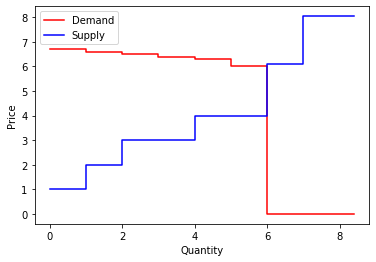

In [38]:
mar = pm.Market()
bids = []

q = 1 # Example orders for testing code:
p = 10
user = 1

mar.accept_bid(1, 6.7, 0, True)
mar.accept_bid(1, 6.6, 1, True)
mar.accept_bid(1, 6.5, 2, True)
mar.accept_bid(1, 6.4, 3, True)
mar.accept_bid(1, 6.3, 4, True)
mar.accept_bid(1, 6, 5, True)

mar.accept_bid(1, 1, 6, False)
mar.accept_bid(1, 2, 7, False)
mar.accept_bid(2, 3, 8, False)
mar.accept_bid(2, 4, 9, False)
mar.accept_bid(1, 6.1, 10, False)
    
for bid in bids:
    mar.accept_bid(*bid)
    
    
mar.bm.get_df()
transactions, extras = mar.run("uniform")
stats = mar.statistics()
mar.plot()
transactions.get_df()
#pprint.pprint(stats)

In [9]:
traders = []

#for i in range(100):
#    exec(f't_{i} = trader(FLAVOUR, FIRM)')

#Run the market over a set number of periods and capture the trading results from it.

#for i in range(1):
#    for i in traders:
#        self.trade() # traders place bids
#    mar.run() # market runs and orders get filled
    # update accounts for each trader
    # record trading price (and other statistics) and generate period's true price
    # traders update beliefs about future
#    print(i)

for period in range(10):
    if period==0:
        ipo = (quantity, 100, mm, False)
        bids.append(ipo)
        for trader in traders:
            trader.trade()
        for bid in bids:
            mar.accept_bid(*bid)
        transactions, extras = mar.run("uniform")
        
            

NameError: name 'quantity' is not defined